In [50]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import numpy as np
import pandas as pd

#from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [52]:
sales=pd.read_pickle('intermed/sales_level_1.sav')
holidays=pd.read_pickle('intermed/holidays.sav')
sales_df=pd.merge(sales, holidays, how='left', left_on=['transaction_date'], right_on=['Date']).drop('Date',axis=1)
sales_df.head()

,DATE_ISO,total_amt,transaction_date,blackFriday2013,blackFriday2012,blackFriday2011,event_value,isMonthEnd,isMonthStart,Weekend_FLG,quarter,month,year,dayofweek,dayofyear,dayofmonth,weekofyear,week_index,seasonal_week_index,Is_holidays
0,20110125,48957.025,2011-01-25,NaN,NaN,NaN,NaN,0,0,0,1,1,2011,1,25,25,4,0,4,0
1,20110126,62045.750,2011-01-26,NaN,NaN,NaN,NaN,0,0,0,1,1,2011,2,26,26,4,0,4,0
2,20110127,30886.960,2011-01-27,NaN,NaN,NaN,NaN,0,0,0,1,1,2011,3,27,27,4,0,4,0
3,20110128,39730.275,2011-01-28,NaN,NaN,NaN,NaN,0,0,0,1,1,2011,4,28,28,4,0,4,0
4,20110129,42027.570,2011-01-29,NaN,NaN,NaN,NaN,0,0,1,1,1,2011,5,29,29,4,0,4,0


In [53]:
lag_features = ['total_amt']
window1 = 3
window2 = 7
window3 = 10
df_rolled_3d = sales_df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = sales_df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_10d = sales_df[lag_features].rolling(window=window3, min_periods=0)



df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_10d = df_rolled_10d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_10d = df_rolled_10d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    sales_df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    sales_df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    sales_df[f"{feature}_mean_lag{window3}"] = df_mean_10d[feature]
    
    sales_df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    sales_df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    sales_df[f"{feature}_std_lag{window3}"] = df_std_10d[feature]

sales_df.fillna(sales_df.mean(), inplace=True)

sales_df.head()

C:\Users\U32118~1\AppData\Local\Temp/ipykernel_1768/789739518.py:28: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  sales_df.fillna(sales_df.mean(), inplace=True)


,DATE_ISO,total_amt,transaction_date,blackFriday2013,blackFriday2012,blackFriday2011,event_value,isMonthEnd,isMonthStart,Weekend_FLG,...,weekofyear,week_index,seasonal_week_index,Is_holidays,total_amt_mean_lag3,total_amt_mean_lag7,total_amt_mean_lag10,total_amt_std_lag3,total_amt_std_lag7,total_amt_std_lag10
0,20110125,48957.025,2011-01-25,-0.5,-0.5,-0.5,-3.0,0,0,0,...,4,0,4,0,48489.902344,48504.019531,48513.519531,12463.856445,13237.000000,13408.194336
1,20110126,62045.750,2011-01-26,-0.5,-0.5,-0.5,-3.0,0,0,0,...,4,0,4,0,48957.023438,48957.023438,48957.023438,12463.856445,13237.000000,13408.194336
2,20110127,30886.960,2011-01-27,-0.5,-0.5,-0.5,-3.0,0,0,0,...,4,0,4,0,55501.386719,55501.386719,55501.386719,9255.125977,9255.125977,9255.125977
3,20110128,39730.275,2011-01-28,-0.5,-0.5,-0.5,-3.0,0,0,0,...,4,0,4,0,47296.578125,47296.578125,47296.578125,15645.618164,15645.618164,15645.618164
4,20110129,42027.570,2011-01-29,-0.5,-0.5,-0.5,-3.0,0,0,1,...,4,0,4,0,44220.996094,45405.003906,45405.003906,16057.473633,13323.005859,13323.005859


In [54]:
exogenous_features=['Is_holidays','seasonal_week_index','blackFriday2013', 'blackFriday2012','blackFriday2011', 
                    'quarter',	'month'	,'year','dayofweek',
                    'dayofyear','dayofmonth',
                    'weekofyear',
                    'event_value','isMonthEnd','isMonthStart','Weekend_FLG',
                    'total_amt_mean_lag3','total_amt_mean_lag7','total_amt_mean_lag10',
                    'total_amt_std_lag3','total_amt_std_lag7','total_amt_std_lag10']

In [55]:
df_train = sales_df[sales_df.transaction_date< "2013-07"]
df_test = sales_df[sales_df.transaction_date>= "2013-07"]

In [14]:
model = auto_arima(df_train.total_amt, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.total_amt)
forecast = model.predict(n_periods=len(df_test))
df_test["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=19492.392, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=19486.706, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19487.358, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19487.467, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21755.958, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=19489.430, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.636 seconds


C:\Users\U32118~1\AppData\Local\Temp/ipykernel_1768/3121394735.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Forecast_ARIMAX"] = forecast


<AxesSubplot:>

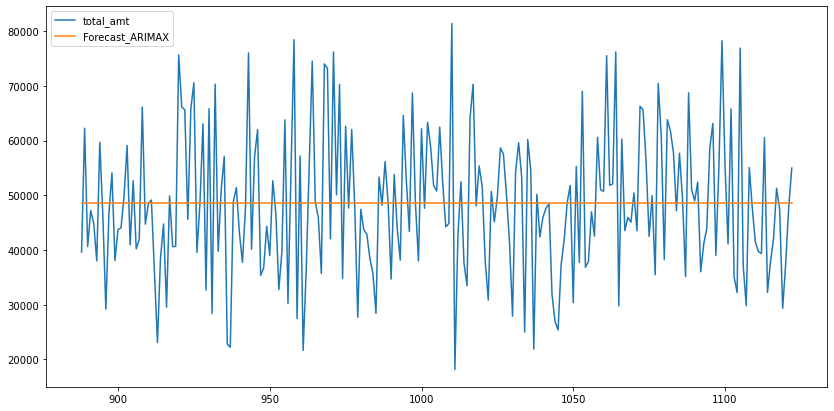

In [15]:
df_test[["total_amt", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [10]:


myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)

In [56]:
# SARIMAX Model
sxmodel = auto_arima(sales_df[['total_amt']], exogenous=sales_df[exogenous_features],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24635.219, Time=6.93 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=24635.374, Time=1.89 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24632.720, Time=4.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24632.638, Time=6.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31399.055, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=24634.595, Time=7.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=24636.409, Time=6.95 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=24630.639, Time=6.97 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=24633.127, Time=9.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=24632.577, Time=9.93 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=24630.720, Time=4.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=24634.406, Time=9.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 73.202 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1123
Model:               SARIMAX(0, 0, 1)   Log Likelihood              -12291.320
Date:                Sun, 23 Jan 2022   AIC                          24630.639
Time:                        14:31:59   BIC                          24751.210
Sample:                             0   HQIC                         24676.206
                               - 1123                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Is_holidays          -1402.0104   2359.881     -0.594      0.552   -6027.292    3223.271
seasonal_week_index    -76.0116     61.957     -1.227      0.220    -197.445      45.422
blackFriday2013       2007.9296   1635.220      1.228      0.219   -1197.042    5212.901
blackFriday2012       2281.6777   1354.611      1.684      0.092    -373.311    4936.666
blackFriday2011       1126.4678   1622.592      0.694      0.488   -2053.755    4306.691
quarter              -1339.8133   1517.625     -0.883      0.377   -4314.304    1634.677
month                -1.182e+04    1.6e+04     -0.739      0.460   -4.31e+04    1.95e+04
year                    28.3574      8.967      3.162      0.002      10.782      45.933
dayofweek              410.4772    338.827      1.211      0.226    -253.611    1074.566
dayofyear              427.9372    527.182      0.812      0.417    -605.320    1461.194
dayofmonth            -371.7672    526.073     -0.707      0.480   -1402.852     659.317
weekofyear             -76.0116     61.957     -1.227      0.220    -197.445      45.422
event_value           -791.3679   1480.235     -0.535      0.593   -3692.575    2109.839
isMonthEnd           -1125.1404   2728.745     -0.412      0.680   -6473.381    4223.101
isMonthStart          -630.5209   2961.979     -0.213      0.831   -6435.893    5174.852
Weekend_FLG           -532.3269   1479.094     -0.360      0.719   -3431.297    2366.644
total_amt_mean_lag3      0.0617      0.081      0.766      0.444      -0.096       0.220
total_amt_mean_lag7      0.1923      0.165      1.166      0.244      -0.131       0.516
total_amt_mean_lag10    -0.1921      0.170     -1.129      0.259      -0.526       0.141
total_amt_std_lag3       0.0160      0.083      0.193      0.847      -0.147       0.179
total_amt_std_lag7      -0.1624      0.204     -0.798      0.425      -0.561       0.237
total_amt_std_lag10      0.1225      0.225      0.544      0.586      -0.318       0.563
ma.L1                   -0.0800      0.037     -2.176      0.030      -0.152      -0.008
sigma2                1.885e+08      0.095   1.99e+09      0.000    1.88e+08    1.88e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.19
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.23
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.42e+25. Standard errors may be unstable.
"""

C:\Users\U32118~1\AppData\Local\Temp/ipykernel_1768/2140666354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Forecast_ARIMAX"] = forecast


<AxesSubplot:>

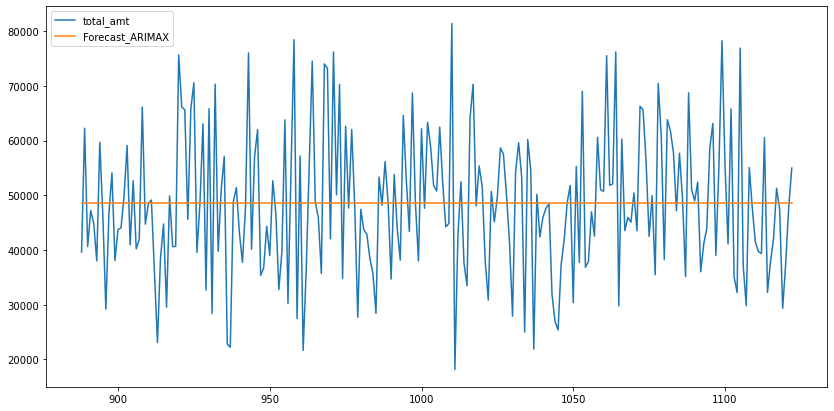

In [57]:
forecast = model.predict(n_periods=len(df_test), exogenous=df_test[exogenous_features])
df_test["Forecast_ARIMAX"] = forecast
df_test[["total_amt", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [29]:
df_test

,DATE_ISO,total_amt,transaction_date,blackFriday2014,blackFriday2013,blackFriday2012,blackFriday2011,event_value,isMonthEnd,isMonthStart,Weekend_FLG,week_index,seasonal_week_index,Is_holidays,total_amt_mean_lag3,total_amt_mean_lag7,total_amt_mean_lag10,total_amt_std_lag3,total_amt_std_lag7,total_amt_std_lag10
888,20130701,39592.150,2013-07-01,100,100,100,100,100,0,1,N,127,27,0,44334.441406,43267.695312,44196.132812,15060.325195,11432.851562,10316.662109
889,20130702,62249.070,2013-07-02,100,100,100,100,100,0,0,N,127,27,0,39449.605469,41919.437500,44463.984375,12374.958008,11194.060547,10139.833008
890,20130703,40608.750,2013-07-03,100,100,100,100,100,0,0,N,127,27,0,51197.964844,45061.742188,45893.300781,11338.641602,13498.395508,11590.380859
891,20130704,47194.550,2013-07-04,100,100,100,100,100,0,0,N,127,27,0,47483.324219,46758.074219,44532.382812,12797.610352,11735.593750,11299.647461
892,20130705,44874.050,2013-07-05,100,100,100,100,100,0,0,N,127,27,0,50017.457031,46092.550781,44348.843750,11092.901367,11528.764648,11233.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,20140216,47419.970,2014-02-16,100,100,100,100,-2,0,0,Y,159,07,0,43731.113281,43292.164062,44716.808594,6869.740723,9519.260742,8715.578125
1119,20140217,29334.435,2014-02-17,100,100,100,100,-3,0,0,N,160,08,0,46920.140625,44394.320312,43954.359375,4633.087891,9481.250977,8017.237793
1120,20140218,37508.120,2014-02-18,100,100,100,100,-4,0,0,N,160,08,0,42679.152344,42964.609375,42125.472656,11717.164062,11002.535156,9100.169922
1121,20140219,47801.195,2014-02-19,100,100,100,100,-5,0,0,N,160,08,0,38087.507812,39671.394531,41730.765625,9056.677734,7858.871582,9217.317383


In [58]:
params = {"objective": "regression"}
dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.total_amt.values)
dvalid = lgb.Dataset(df_test[exogenous_features])
model_lgb = lgb.train(params, train_set=dtrain)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 888, number of used features: 18
[LightGBM] [Info] Start training from score 48513.024028


C:\Users\U32118~1\AppData\Local\Temp/ipykernel_1768/1643931981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Forecast_LGM"] = forecast


<AxesSubplot:>

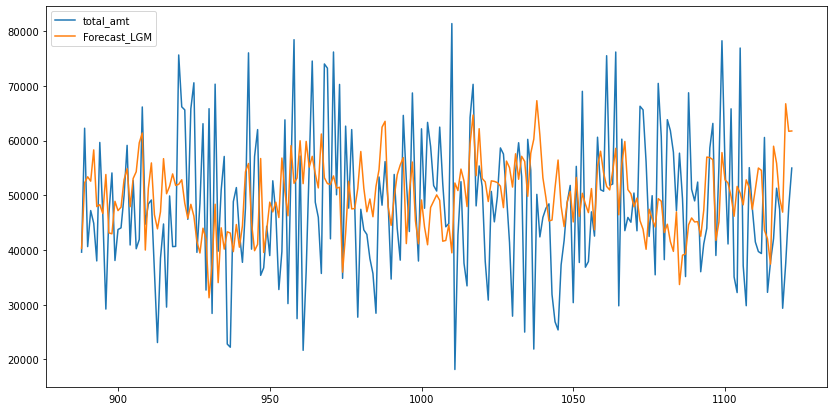

In [59]:
forecast = model_lgb.predict(df_test[exogenous_features])
df_test["Forecast_LGM"] = forecast
df_test[["total_amt","Forecast_LGM"]].plot(figsize=(14, 7))

In [60]:
X_train, y_train = df_train[exogenous_features],  df_train['total_amt']
X_test, y_test   = df_test[exogenous_features], df_test['total_amt']

In [76]:
df_train[exogenous_features]

,Is_holidays,seasonal_week_index,blackFriday2013,blackFriday2012,blackFriday2011,quarter,month,year,dayofweek,dayofyear,...,event_value,isMonthEnd,isMonthStart,Weekend_FLG,total_amt_mean_lag3,total_amt_mean_lag7,total_amt_mean_lag10,total_amt_std_lag3,total_amt_std_lag7,total_amt_std_lag10
0,0,4,100,100,100,1,1,2011,1,25,...,100,0,0,0,48489.902344,48504.019531,48513.519531,12463.856445,13237.000000,13408.194336
1,0,4,100,100,100,1,1,2011,2,26,...,100,0,0,0,48957.023438,48957.023438,48957.023438,12463.856445,13237.000000,13408.194336
2,0,4,100,100,100,1,1,2011,3,27,...,100,0,0,0,55501.386719,55501.386719,55501.386719,9255.125977,9255.125977,9255.125977
3,0,4,100,100,100,1,1,2011,4,28,...,100,0,0,0,47296.578125,47296.578125,47296.578125,15645.618164,15645.618164,15645.618164
4,0,4,100,100,100,1,1,2011,5,29,...,100,0,0,0,44220.996094,45405.003906,45405.003906,16057.473633,13323.005859,13323.005859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,0,26,100,100,100,2,6,2013,2,177,...,100,0,0,0,47833.609375,48904.457031,44839.351562,7058.942383,8532.113281,10046.072266
884,0,26,100,100,100,2,6,2013,3,178,...,100,0,0,0,39339.105469,44096.289062,43538.656250,10178.581055,9127.606445,11260.379883
885,0,26,100,100,100,2,6,2013,4,179,...,100,0,0,0,40280.195312,44136.855469,45859.710938,11559.428711,9166.904297,10190.056641
886,0,26,100,100,100,2,6,2013,5,180,...,100,0,0,0,44944.769531,46613.003906,47716.550781,14089.489258,9231.348633,9813.456055


In [79]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change ver

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

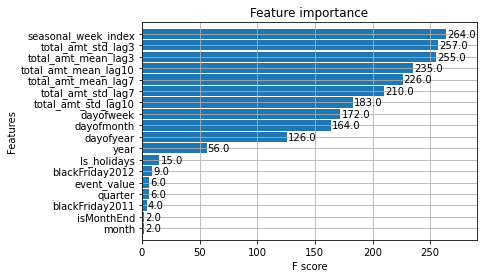

In [76]:
xgb.plot_importance(reg, height=0.9)

C:\Users\U32118~1\AppData\Local\Temp/ipykernel_1768/2628073917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Forecast_XGB"] = forecast


<AxesSubplot:>

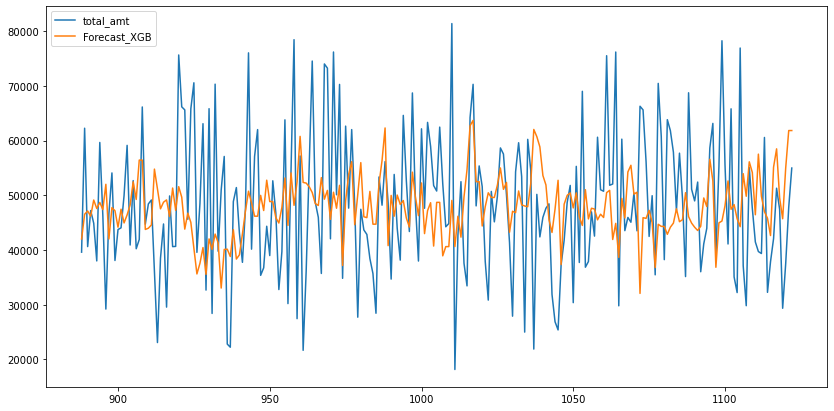

In [47]:
forecast = m.predict(df_test[exogenous_features])
df_test["Forecast_XGB"] = forecast
df_test[["total_amt","Forecast_XGB"]].plot(figsize=(14, 7))

C:\Users\U32118~1\AppData\Local\Temp/ipykernel_12512/3382729081.py:28: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  sales_df.fillna(sales_df.mean(), inplace=True)


,DATE_ISO,total_amt,transaction_date,blackFriday2014,blackFriday2013,blackFriday2012,blackFriday2011,event_value,isMonthEnd,isMonthStart,...,year,dayofyear,dayofmonth,weekofyear,total_amt_mean_lag3,total_amt_mean_lag7,total_amt_mean_lag10,total_amt_std_lag3,total_amt_std_lag7,total_amt_std_lag10
0,20110125,48957.025,2011-01-25,100,100,100,100,100,0,0,...,2011,25,25,4,48489.902344,48504.019531,48513.519531,12463.856445,13237.000000,13408.194336
1,20110126,62045.750,2011-01-26,100,100,100,100,100,0,0,...,2011,26,26,4,48957.023438,48957.023438,48957.023438,12463.856445,13237.000000,13408.194336
2,20110127,30886.960,2011-01-27,100,100,100,100,100,0,0,...,2011,27,27,4,55501.386719,55501.386719,55501.386719,9255.125977,9255.125977,9255.125977
3,20110128,39730.275,2011-01-28,100,100,100,100,100,0,0,...,2011,28,28,4,47296.578125,47296.578125,47296.578125,15645.618164,15645.618164,15645.618164
4,20110129,42027.570,2011-01-29,100,100,100,100,100,0,0,...,2011,29,29,4,44220.996094,45405.003906,45405.003906,16057.473633,13323.005859,13323.005859


In [80]:
# Define the function hyperopt must optimise
def objective(params):
    num_round = int(params['n_estimators'])
    xgb_reg = xgb.train(params, X_train_matrix, num_round)
    y_pred = xgb_reg.predict(X_test_matrix)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Make DMatrix for calling function, to optimise speed of training
X_train_matrix = xgb.DMatrix(X_train, label=y_train)
X_test_matrix = xgb.DMatrix(X_test)

In [81]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Définir l'espace d'optimisation
space = {
    'verbosity': 0, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 
    'max_depth': hp.choice('max_depth', np.arange(4, 10, 1, dtype=int)), # Maximum depth of a tree. L'augmentation de cette valeur rendra le modèle plus complexe et plus susceptible de sur-ajuster. 0 n'est accepté dans la politique de croissance guidée par perte que lorsque tree_method est défini sur hist et qu'il n'indique aucune limite de profondeur. Méfiez-vous que XGBoost consomme agressivement de la mémoire lors de la formation d'un arbre profond. intervalle: [0,∞] 
    'n_estimators': hp.choice('n_estimators', np.arange(5, 50, 1, dtype=int)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 0.7, 0.05), # colsample_bytree, colsample_bylevel, colsample_bynode [default=1]. Il s'agit d'une famille de paramètres pour le sous-échantillonnage des colonnes. colsample_bytree est le rapport de sous-échantillon des colonnes lors de la construction de chaque arbre. Le sous-échantillonnage a lieu une fois pour chaque arbre construit. Tous les paramètres colsample_by* ont une plage de (0, 1], la valeur par défaut de 1, et spécifient la fraction de colonnes à sous-échantillonner.
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 5, 1, dtype=int)), # Minimum sum of instance weight (hessian) needed in a child. Si l'étape de partition de l'arborescence aboutit à un nœud feuille avec la somme du poids de l'instance inférieure à min_child_weight, le processus de construction abandonnera le partitionnement supplémentaire. Dans le cas  de régression linéaire, cela correspond simplement au nombre minimum d'instances nécessaires pour chaque nœud. Plus min_child_weight est grand, plus l'algorithme sera conservateur.  range: [0,∞]
    'subsample': hp.quniform('subsample', 0.3, 1, 0.05), # Subsample ratio of the training instances. Le régler sur 0,5 signifie que XGBoost échantillonnerait au hasard la moitié des données d'entraînement avant de faire pousser des arbres, ce qui évitera le surajustement. Le sous-échantillonnage se produira une fois dans chaque itération de boosting. intervalle: (0,1]
    'gamma': hp.quniform('gamma', 140, 180, 2), # Réduction minimale des pertes requise pour créer une partition supplémentaire sur un nœud feuille de l'arbre. Plus le gamma est grand, plus l'algorithme sera conservateur.  intervalle = [0,∞]
    'learning_rate': hp.quniform('learning_rate', 0.1, 0.6, 0.05),# alias: eta.  Default is 0.3.  Range is [0,1]. Réduction de taille de pas utilisée dans la mise à jour pour éviter le surajustement. Après chaque étape de boosting, nous pouvons directement obtenir le poids des nouvelles features, et eta réduit le poids des features pour rendre le processus de boosting plus conservateur.
    'objective': 'reg:squarederror',
    'lambda': hp.quniform('lambda', 10, 20, 1), #  regularisation L2 des terms poids.. L'augmentation de cette valeur rendra le modèle plus conservateur.
    'alpha': hp.quniform('alpha', 50, 60, 1), #   regularisation L1 des terms poids. L'augmentation de cette valeur rendra le modèle plus conservateur.
    'eval_metric': 'rmse',
    'X_train_matrix': X_train_matrix, 
    'X_test_matrix': X_test_matrix, 
    'y_test': y_test
}

In [ ]:
params=best

In [82]:
# Exécuter l'optimisation hyperopttrials = Trials()
best = fmin(
    fn=objective,  # objective function
    space=space,   # parameter space
    algo=tpe.suggest,  # surrogate algorithm
    max_evals=2000,  # no. of evaluations
    trials=trials  # trials object that keeps track of the sample results (optional).  In order to run with trails the output of the objective function has to be a dictionary including at least the keys 'loss' and 'status' which contain the result and the optimization status respectively.
        )

# Imprimer les paramètres optimisés
print("Best = ", best)

100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<?, ?trial/s, best loss=?]
Best =  {'alpha': 52.0, 'colsample_bytree': 0.30000000000000004, 'gamma': 180.0, 'lambda': 20.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 43, 'subsample': 0.55}


In [97]:
reg = xgb.XGBRegressor(alpha=52.0, 
                       reg_lambda = 20, 
                       colsample_bytree= 0.30000000000000004,
                       gamma= 180, 
                       learning_rate= 0.1, 
                       max_depth=6,
                       min_child_weight= 4,
                       n_estimators= 43, 
                       subsample= 0.55)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric="rmse",
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change ver

XGBRegressor(alpha=52.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.30000000000000004,
             enable_categorical=False, gamma=180, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=43, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=52, reg_lambda=20, scale_pos_weight=1,
             subsample=0.55, tree_method='exact', validate_parameters=1,
             verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

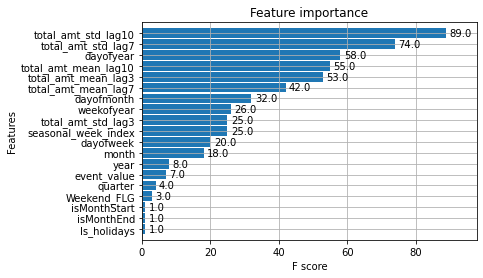

In [98]:
xgb.plot_importance(reg, height=0.9)

C:\Users\U32118~1\AppData\Local\Temp/ipykernel_1768/3897755506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Forecast_XGB_tune"] = forecast


<AxesSubplot:>

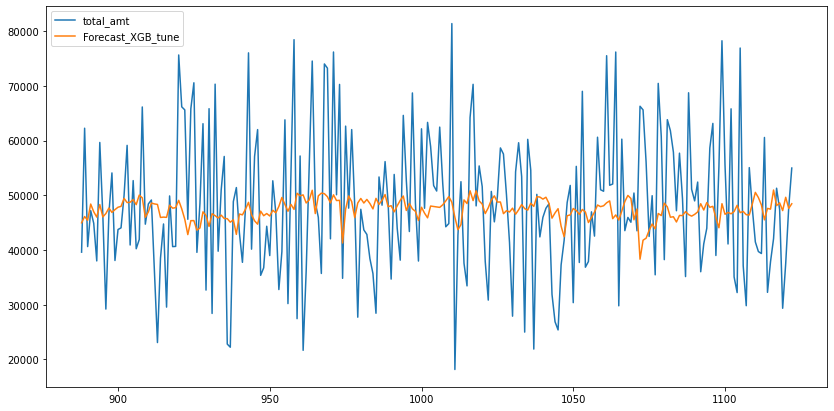

In [99]:
forecast = reg.predict(df_test[exogenous_features])
df_test["Forecast_XGB_tune"] = forecast
df_test[["total_amt","Forecast_XGB_tune"]].plot(figsize=(14, 7))